# 1.4 - Testing Handwriting

## Imports

In [1]:
%matplotlib inline
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.
import glob

import imageio

import pandas as pd # to manage data frames and reading csv files

import operator

## Global Variables

In [2]:
#number of input, hidden and output nodes
input_nodes = 784 #we have a 28x28 matrix to describe each digit
hidden_nodes = 250
output_nodes = 10

learning_rate = 0.2
batch_size = 3 # increase this if you want batch gradient descent

# epochs is the number of training iterations 
epochs = 20

# datasets to read
# you can change these when trying out other datasets
train_file = "mnist_train.csv"
test_file = "mnist_test.csv"

## Helpers

### Activations

In [3]:
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
    def backward(self, inputs):
        self.output = np.greater(inputs, 0).astype(int) # inputs > 0 then convert bools to int
        
class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))

### Evaluations

In [4]:
def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=targets.size
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """
    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()
    return accuracy

#Finally, we can test to see how many of the test instances we got correct
def accuracyknn(results):
    correct = 0
    for predict, target in results:
            
        if predict == target:
            correct += 1
    return (correct/float(len(results))) * 100.0

### Load MNIST Data

In [5]:
#load the mnist training data CSV file into a frame
df_orig_train = pd.read_csv(train_file, header=None)  # read entire train dataset
df_orig_test = pd.read_csv(test_file, header=None)  # read entire test dataset
#df_orig_train.info()

### ANN

In [6]:
y_train_all =  pd.get_dummies(df_orig_train[0]).values
X_train_all = df_orig_train.drop(0, axis = 1).values
print(y_train_all.shape)
print(X_train_all.shape)

y_test_all =  pd.get_dummies(df_orig_test[0]).values
X_test_all = df_orig_test.drop(0, axis = 1).values
print(y_test_all.shape)
print(X_test_all.shape)

(60000, 10)
(60000, 784)
(10000, 10)
(10000, 784)


### kNN

In [7]:
kNN_y_train_all =  df_orig_train[0].values
kNN_X_train_all = df_orig_train.drop(0, axis = 1).values
print(kNN_y_train_all.shape)
print(kNN_X_train_all.shape)

kNN_y_test_all =  df_orig_test[0].values
kNN_X_test_all = df_orig_test.drop(0, axis = 1).values
print(kNN_y_test_all.shape)
print(kNN_X_test_all.shape)

(60000,)
(60000, 784)
(10000,)
(10000, 784)


### PreProcessors

In [8]:
# Select smaller samples of the train and test datasets (will execute faster when training our networks than using the entire dataset)
train_sample_size = 1500  # choosing a smaller sample instead of the entire dataset
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)

### ANN

In [9]:
X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
print(y_train.shape)
print(X_train.shape)

#preprocessing steps
X_train = (X_train / 255.0 * 0.99) + 0.01
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)
print(y_train.shape)

test_sample_size = 100 
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
X_test = X_test_all[random_test_indices]
y_test = y_test_all[random_test_indices]
print(y_test.shape)
print(X_test.shape)

X_test = (X_test / 255.0 * 0.99) + 0.01
y_test = y_test + 0.01
y_test = np.where(y_test != 1.01, y_test, 0.99)
print(y_test.shape)
print(X_test.shape)

(1500, 10)
(1500, 784)
(1500, 10)
(100, 10)
(100, 784)
(100, 10)
(100, 784)


### kNN

In [10]:
kNN_X_train = kNN_X_train_all[random_indices]
kNN_y_train = kNN_y_train_all[random_indices]
print(kNN_y_train.shape)
print(kNN_X_train.shape)

#preprocessing steps
kNN_X_train = (kNN_X_train / 255.0 * 0.99) + 0.01
kNN_y_train = kNN_y_train
print(kNN_y_train.shape)

test_sample_size = 100 
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
kNN_X_test = kNN_X_test_all[random_test_indices]
kNN_y_test = kNN_y_test_all[random_test_indices]
print(kNN_y_test.shape)
print(kNN_X_test.shape)

kNN_X_test = (kNN_X_test / 255.0 * 0.99) + 0.01
kNN_y_test = kNN_y_test

(1500,)
(1500, 784)
(1500,)
(100,)
(100, 784)


## Import Custom Images

In [11]:
def get_my_test_data(folder):
    # our own image test data set
    X = []
    y = []
    
    # to read jpg change the regex to '/*.jpg'
    folder_expr = folder + '/*.png'
    print(folder_expr)

    for image_file_name in glob.glob(folder_expr): 
        print ("loading ... ", image_file_name)

        # load image data from png files into an array
        img_array = imageio.imread(image_file_name, as_gray=True)
        # reshape from 28x28 to list of 784 values, invert values
        img_data  = 255.0 - img_array.reshape(784)
        # then scale data to range from 0.01 to 1.0
        inputs = (img_data / 255.0 * 0.99) + 0.01
        
        # use the filename to set the correct label
        digit_class = int(image_file_name[-5:-4]) #negative indices for indexing from the end of the array
        
        X.insert(len(X), inputs)
        y.insert(len(y), digit_class)
       
        pass
    return(X,y)
pass

my_images/*.png
loading ...  my_images\b0.png
loading ...  my_images\b1.png
loading ...  my_images\b2.png
loading ...  my_images\b3.png
loading ...  my_images\b4.png
loading ...  my_images\b5.png
loading ...  my_images\b6.png
loading ...  my_images\b7.png
loading ...  my_images\b8.png
loading ...  my_images\b9.png
loading ...  my_images\c1.png
loading ...  my_images\c2.png
loading ...  my_images\c3.png
loading ...  my_images\c4.png
loading ...  my_images\c5.png
loading ...  my_images\c6.png
loading ...  my_images\c7.png
loading ...  my_images\c8.png
loading ...  my_images\c9.png
loading ...  my_images\n0.png
loading ...  my_images\n1.png
loading ...  my_images\n2.png
loading ...  my_images\n3.png
loading ...  my_images\n4.png
loading ...  my_images\n5.png
loading ...  my_images\n6.png
loading ...  my_images\n7.png
loading ...  my_images\n8.png
loading ...  my_images\n9.png


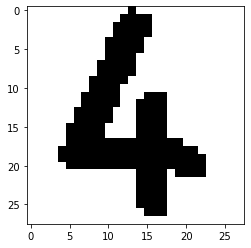

In [12]:
X_my_test, y_my_test = get_my_test_data('my_images') # my_images is a subfolder in the current folder 

# lets plot one of the created images that was read into X_my_test
# now reshape the 784 features into a 28x28 grid
# here asfarray helps to convert values into real numbers
image_array = np.asfarray(X_my_test[4]).flatten().reshape((28,28))

# print the grid in grey scale
plt.imshow(image_array, cmap='Greys', interpolation='None') 

## Duplicate and Convert for ANN

In [13]:
#MNIST dataset assume output_nodes = 10 for the ANN

# converts the data to a format that the ANN class can use for training the model
# this eseentially , maps a given target class label to an outputs vector (y_vec) thats compatible 
# with the ANN's output layer. 

#output_nodes = 10
def map_target_to_output_layer(instances, targets):
    X=[]
    Y=[]
    for inputs, target in zip(instances, targets):
        # create the target output values (all 0.01, except the desired label which is 0.99)
        y_vec = np.zeros(output_nodes) + 0.01
        y_vec[int(target)] = 0.99
        #print('output', target)
        
        X.insert(len(X), inputs) # simply inserting these they are already in the correct format
        Y.insert(len(Y), y_vec) # inserting these after the vector mapping
        #print(y_vec)
    pass
    return(X,Y)
pass

ann_X_my_test, ann_y_my_test = get_my_test_data('my_images')
ann_X_my_test, ann_y_my_test = map_target_to_output_layer(ann_X_my_test, ann_y_my_test)

my_images/*.png
loading ...  my_images\b0.png
loading ...  my_images\b1.png
loading ...  my_images\b2.png
loading ...  my_images\b3.png
loading ...  my_images\b4.png
loading ...  my_images\b5.png
loading ...  my_images\b6.png
loading ...  my_images\b7.png
loading ...  my_images\b8.png
loading ...  my_images\b9.png
loading ...  my_images\c1.png
loading ...  my_images\c2.png
loading ...  my_images\c3.png
loading ...  my_images\c4.png
loading ...  my_images\c5.png
loading ...  my_images\c6.png
loading ...  my_images\c7.png
loading ...  my_images\c8.png
loading ...  my_images\c9.png
loading ...  my_images\n0.png
loading ...  my_images\n1.png
loading ...  my_images\n2.png
loading ...  my_images\n3.png
loading ...  my_images\n4.png
loading ...  my_images\n5.png
loading ...  my_images\n6.png
loading ...  my_images\n7.png
loading ...  my_images\n8.png
loading ...  my_images\n9.png


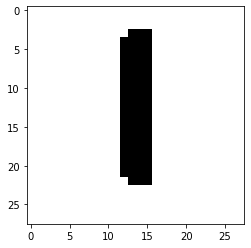

In [14]:
image_array = np.asfarray(ann_X_my_test[1]).flatten().reshape((28,28))
# print the grid in grey scale
plt.imshow(image_array, cmap='Greys', interpolation='None') 

## Define Similarity Metrics

In [15]:
#Within our class we now need code for each of the components of k-NN.
#First, let's create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)
    
def cosine(instance1, instance2):
        cossime = dot(instance1, instance20/(norm(instance1)*norm(instance2)))
        return cossime

## Class Layer_Dense to Build Layers

In [16]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, learningrate=0.01, activation='sigmoid'):
        
        self.weights = np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        print(self.weights.shape)
        self.biases = np.zeros((1, n_neurons))
       
        self.lr = learningrate
        self.activate=activation  
        
    def forward(self, inputs):
        self.in_values = inputs
        self.layer_input = np.dot(inputs , self.weights) + self.biases
        self.activation()
    
    def activation(self):
        if self.activate == 'sigmoid':
            a = Activation_Sigmoid()
            self.layer_output = a.forward(self.layer_input)
            
           
    def del_activation(self):
        if self.activate == 'sigmoid':
            del_a = Activation_Sigmoid()
            self.del_layer_output =  del_a.backward(del_a.forward(self.layer_input))
      
    def backward(self, delta_in, weights_in, targets=None, output_layer=False):
        self.del_activation()
        if output_layer:
            self.layer_error = self.layer_output - targets
            self.layer_delta = self.layer_error * self.del_layer_output
        else:          
            self.layer_error = np.dot(delta_in, weights_in.T)
            self.layer_delta = self.layer_error * self.del_layer_output
        
    def weight_update(self, prev_layer_output):
        # print("prev_layer_output.T.shape: "+str(prev_layer_output.T.shape))
        # print("self.layer_delta.shape: "+str(self.layer_delta.shape))
        N = self.layer_delta.shape[0]
        weights_update = np.dot(prev_layer_output.T, self.layer_delta) / N
        # print(weights_update.shape)
        self.weights -= self.lr * weights_update
        biases_update = np.mean(self.layer_delta, axis=0, keepdims=True)
        # print("biases_update.shape: "+ str(biases_update.shape))
        # print("self.biases.shape: "+ str(self.biases.shape))
        self.biases -= self.lr * biases_update

## Build ANN Class

In [17]:
class ANN():
    def __init__(self, ouput_layer, hidden_layer, batch_size = 10):
        self.output = ouput_layer
        self.layer1 = hidden_layer
        self.batch_size = batch_size

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, lr):
        self.layer1.lr = lr
        self.output.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x)
                # print('layer1 output \n' ,layer1.layer_output.shape)
                self.output.forward(self.layer1.layer_output)
                # print('layer output  \n', output.layer_output.shape)

                # backprop through the layers 
                self.output.backward(None, None, batch_y, True)
                # print('layer out delta  \n', output.layer_delta.shape)
                self.layer1.backward(self.output.layer_delta, self.output.weights)
                # print('layer1 delta  \n', layer1.layer_delta.shape)

                # update all the layer weights
                self.output.weight_update(self.layer1.layer_output)
                # print('layer weights  \n', output.weights.shape)
                self.layer1.weight_update(batch_x)
                # print('layer weights  \n', layer1.weights.shape)
            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x)
        self.output.forward(self.layer1.layer_output)
        return self.output.layer_output

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)

## Build kNN Class

In [18]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=1, sim=euclidean, weighted=True):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        for x in range(self.k): #extract the k top indices of the collection for return
            neighbours.append(similarities[x])

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)

## Train ANN

### Regular Data

In [19]:
ann_X_my_test = np.array(ann_X_my_test)
ann_y_my_test = np.array(ann_y_my_test)

np.random.seed(42)

# set other hyperparameters
batch_size = 1
epochs = 10
lr = 0.3

# configure the layers
hidden = Layer_Dense(784,200)
output = Layer_Dense(200,10)

# create an ANN model
ann = ANN(output, hidden, batch_size)

# train the ANN model with training data
train_performance = ann.train(X_train, y_train, epochs, lr)

train_performance

ann_list = []
train_performance_list = []

# create an ANN model
ann = ANN(output, hidden, batch_size)

# train the ANN model with training data
train_performance = ann.train(X_train, y_train, epochs, lr)
train_performance
    
#test the model
df_test_result = ann.test(ann_X_my_test, ann_y_my_test)
  
acc=df_test_result['accuracy'].values
print("Accuracy ", '%.4f' % acc[0])
annAcc = float(acc[0] * 100)
print(annAcc)

(784, 200)
(200, 10)
Accuracy  0.3793
37.93103448275862


## Train kNN

### Regular Data

In [20]:
np.random.seed(42)

knn_list = []

#create the different instances of the kNN class
knn = kNN(kNN_X_train, kNN_y_train, 1, euclidean, True)     
knn.test(X_my_test, y_my_test)
knn_list.append(knn)# now append the set of models 

In [21]:
print("Accuracy ", '%.4f' %  accuracyknn(knn_list[0].results))
knnAcc = float(accuracyknn(knn_list[0].results))

Accuracy  37.9310


## Model ANN vs kNN on Handwriting

In [22]:
combined_acc = []
combined_acc.append(annAcc)
combined_acc.append(knnAcc)

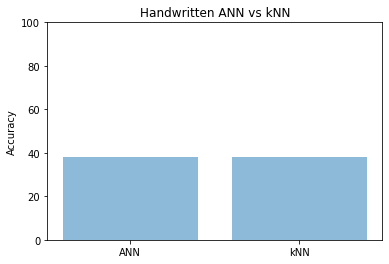

In [23]:
objects = ['ANN', 'kNN']
y_pos = np.arange(len(objects))
performance = combined_acc

batchsize_axes = plt.gca()
batchsize_axes.set_ylim([0,100])

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Handwritten ANN vs kNN')

plt.show()